##### Copyright 2019 The TensorFlow Authors.

In [ ]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

In [33]:
import os

from tensorflow.keras import layers
from tensorflow.keras import Model
!wget --no-check-certificate \
    https://storage.googleapis.com/mledu-datasets/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5 \
    -O /tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5
  
from tensorflow.keras.applications.inception_v3 import InceptionV3

local_weights_file = '/tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5'

pre_trained_model = InceptionV3(input_shape = (150, 150, 3), 
                                include_top = False, 
                                weights = None)

pre_trained_model.load_weights(local_weights_file)

for layer in pre_trained_model.layers:
  layer.trainable = False
  
# pre_trained_model.summary()

last_layer = pre_trained_model.get_layer('mixed7')
print('last layer output shape: ', last_layer.output_shape)
last_output = last_layer.output

--2021-01-11 17:51:32--  https://storage.googleapis.com/mledu-datasets/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.20.128, 74.125.195.128, 74.125.142.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.20.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 87910968 (84M) [application/x-hdf]
Saving to: ‘/tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5’

/tmp/inception_v3_w 100%[===================>]  83.84M   206MB/s    in 0.4s    

2021-01-11 17:51:32 (206 MB/s) - ‘/tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5’ saved [87910968/87910968]

last layer output shape:  (None, 7, 7, 768)


In [34]:
from tensorflow.keras.optimizers import RMSprop

# Flatten the output layer to 1 dimension
x = layers.Flatten()(last_output)
# Add a fully connected layer with 1,024 hidden units and ReLU activation
x = layers.Dense(1024, activation='relu')(x)
# Add a dropout rate of 0.2
x = layers.Dropout(0.2)(x)                  
# Add a final sigmoid layer for classification
x = layers.Dense  (1, activation='sigmoid')(x)           

model = Model( pre_trained_model.input, x) 

model.compile(optimizer = RMSprop(lr=0.0001), 
              loss = 'binary_crossentropy', 
              metrics = ['accuracy'])


In [35]:
!wget --no-check-certificate \
        https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip \
       -O /tmp/cats_and_dogs_filtered.zip

from tensorflow.keras.preprocessing.image import ImageDataGenerator

import os
import zipfile

local_zip = '//tmp/cats_and_dogs_filtered.zip'

zip_ref = zipfile.ZipFile(local_zip, 'r')

zip_ref.extractall('/tmp')
zip_ref.close()

# Define our example directories and files
base_dir = '/tmp/cats_and_dogs_filtered'

train_dir = os.path.join( base_dir, 'train')
validation_dir = os.path.join( base_dir, 'validation')


train_cats_dir = os.path.join(train_dir, 'cats') # Directory with our training cat pictures
train_dogs_dir = os.path.join(train_dir, 'dogs') # Directory with our training dog pictures
validation_cats_dir = os.path.join(validation_dir, 'cats') # Directory with our validation cat pictures
validation_dogs_dir = os.path.join(validation_dir, 'dogs')# Directory with our validation dog pictures

train_cat_fnames = os.listdir(train_cats_dir)
train_dog_fnames = os.listdir(train_dogs_dir)

# Add our data-augmentation parameters to ImageDataGenerator
train_datagen = ImageDataGenerator(rescale = 1./255.,
                                   rotation_range = 40,
                                   width_shift_range = 0.2,
                                   height_shift_range = 0.2,
                                   shear_range = 0.2,
                                   zoom_range = 0.2,
                                   horizontal_flip = True)

# Note that the validation data should not be augmented!
test_datagen = ImageDataGenerator( rescale = 1.0/255. )

# Flow training images in batches of 20 using train_datagen generator
train_generator = train_datagen.flow_from_directory(train_dir,
                                                    batch_size = 20,
                                                    class_mode = 'binary', 
                                                    target_size = (150, 150))     

# Flow validation images in batches of 20 using test_datagen generator
validation_generator =  test_datagen.flow_from_directory( validation_dir,
                                                          batch_size  = 20,
                                                          class_mode  = 'binary', 
                                                          target_size = (150, 150))

--2021-01-11 17:51:42--  https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.195.128, 74.125.142.128, 173.194.202.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.195.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 68606236 (65M) [application/zip]
Saving to: ‘/tmp/cats_and_dogs_filtered.zip’

/tmp/cats_and_dogs_ 100%[===================>]  65.43M  94.2MB/s    in 0.7s    

2021-01-11 17:51:43 (94.2 MB/s) - ‘/tmp/cats_and_dogs_filtered.zip’ saved [68606236/68606236]

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


In [36]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [42]:
# bat chuoc cai nay: https://github.com/wtfleming/jupyter-notebooks-public/blob/master/dogs-vs-cats/dogs-vs-cats-part-2.ipynb
# 98% nhung co ve overfitting

from tensorflow.keras import layers, models, optimizers
from tensorflow.keras.applications import VGG16

conv_base = VGG16(weights='imagenet',
                  include_top=False,
                  input_shape=(224, 224, 3))

conv_base.trainable = True

set_trainable = False
for layer in conv_base.layers:
    if layer.name == 'block5_conv1':
        set_trainable = True
    if set_trainable:
        layer.trainable = True
    else:
        layer.trainable = False

In [45]:
from tensorflow.keras.applications.vgg16 import preprocess_input
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)
test_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)

In [46]:
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(224, 224), # resize all images to 150 x 150
    batch_size=50,
    class_mode='binary') # because we use binary_crossentropy loss we need binary labels

validation_generator = test_datagen.flow_from_directory(
    validation_dir,
    target_size=(224, 224), # resize all images to 150 x 150
    batch_size=50,
    class_mode='binary')

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


In [47]:
model = models.Sequential()
model.add(conv_base)
model.add(layers.Flatten())
model.add(layers.Dropout(0.5))
model.add(layers.Dense(256, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy',
              optimizer=optimizers.RMSprop(lr=1e-5),
              metrics=['acc'])

In [48]:
history = model.fit_generator(
    train_generator,
    steps_per_epoch=40,
    epochs=30,
    validation_data=validation_generator,
    validation_steps=20) 

/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/30
40/40 [==============================] - 18s 380ms/step - loss: 4.2725 - acc: 0.7034 - val_loss: 0.4088 - val_acc: 0.9300
Epoch 2/30
40/40 [==============================] - 15s 374ms/step - loss: 0.6578 - acc: 0.8976 - val_loss: 0.2376 - val_acc: 0.9540
Epoch 3/30
40/40 [==============================] - 15s 376ms/step - loss: 0.3225 - acc: 0.9405 - val_loss: 0.2528 - val_acc: 0.9540
Epoch 4/30
40/40 [==============================] - 15s 382ms/step - loss: 0.2283 - acc: 0.9722 - val_loss: 0.1696 - val_acc: 0.9660
Epoch 5/30
40/40 [==============================] - 15s 381ms/step - loss: 0.0864 - acc: 0.9807 - val_loss: 0.1335 - val_acc: 0.9690
Epoch 6/30
40/40 [==============================] - 15s 377ms/step - loss: 0.0590 - acc: 0.9890 - val_loss: 0.1228 - val_acc: 0.9700
Epoch 7/30
40/40 [==============================] - 15s 374ms/step - loss: 0.0300 - acc: 0.9905 - val_loss: 0.2070 - val_acc: 0.9670
Epoch 8/30
40/40 [==============================] - 15s 376ms/step - 

In [49]:
model.save("drive/MyDrive/ML_colab/save/cat_dog/SaveModel_cat_dog_md_cp1")
model.save("drive/MyDrive/ML_colab/save/cat_dog/model_cat_dog_md_cp1.h5")

INFO:tensorflow:Assets written to: drive/MyDrive/ML_colab/save/cat_dog/SaveModel_cat_dog_md_cp1/assets


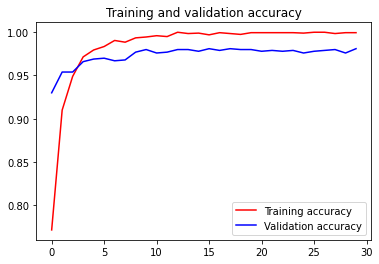

<Figure size 432x288 with 0 Axes>

In [51]:
import matplotlib.pyplot as plt
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend(loc=0)
plt.figure()


plt.show()

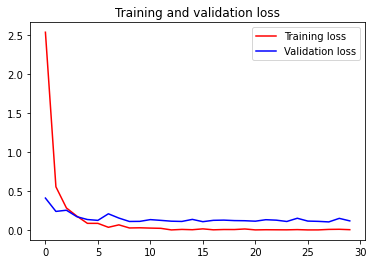

<Figure size 432x288 with 0 Axes>

In [52]:
# loss
epochs = range(len(loss))
plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend(loc=0)
plt.figure()
plt.show()

In [57]:
file_path = 'drive/MyDrive/ML_colab/dataset/test_cat_dog/' # current dir
test_files = os.listdir(file_path)

for file in test_files:
    # predicting images
    path=file_path + file
    img=image.load_img(path, target_size=(224, 224))

    x=image.img_to_array(img)
    x=np.expand_dims(x, axis=0)
    images = np.vstack([x])

    classes = model.predict_classes(images, batch_size=10)
    # classes = np.argmax(classes, axis=1)

    print(classes[0])

    thresh_hold = 0.6;

    if classes[0]>thresh_hold:
        print(file + " is a dog")

    else:
        print(file + " is a cat")

[1.]
dog4.jpeg is a dog
[0.99999976]
dog1.jpg is a dog
[1.]
dog3.jpg is a dog
[1.]
dog2.jpg is a dog
[4.0381816e-29]
cat.jpeg is a cat
[1.0474725e-28]
cat_2.jpeg is a cat


In [56]:
classes

array([[1.0474725e-28]], dtype=float32)

In [59]:
from tensorflow.keras.preprocessing import image
test_file = "drive/MyDrive/ML_colab/dataset/test_cat_dog/cat_2.jpeg"
img = image.load_img(test_file, target_size=(224, 224))
x = image.img_to_array(img)
x = np.expand_dims(x, axis=0)
images = np.vstack([x])

classes = model.predict(images)
classes

array([[1.0474725e-28]], dtype=float32)

In [60]:
model.predict_classes(images)

/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


array([[0]], dtype=int32)

In [37]:
import tensorflow as tf

In [38]:
# Define a Callback class that stops training once accuracy reaches 97.0%
class myCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs={}):
        if(logs.get('accuracy') is not None and logs.get('val_accuracy') > 0.96) :
            print("\nReached 97.0% accuracy so cancelling training!")
            self.model.stop_training = True

my_callback = myCallback()

In [ ]:
# # Save checkpoints during training
# # ref: https://www.tensorflow.org/tutorials/keras/save_and_load#save_checkpoints_during_training
# # checkpoint_path = "../checkpoint/cp-{epoch:04d}.ckpt"
# checkpoint_path = "drive/MyDrive/ML_colab/cat_dog/cp-{epoch:04d}.ckpt"
# checkpoint_dir = os.path.dirname(checkpoint_path)
# cp_callback = tf.keras.callbacks.ModelCheckpoint(
#     filepath=checkpoint_path,
#     save_weights_only=True,
#     save_freq=5*20,
#     verbose=1)

In [ ]:
history = model.fit(
            train_generator,
            validation_data = validation_generator,
            steps_per_epoch = 100,
            epochs = 20,
            validation_steps = 50,
            verbose = 2,
            # callbacks=[my_callback, cp_callback])
            callbacks=[my_callback])

Epoch 1/20
100/100 - 28s - loss: 0.3480 - accuracy: 0.8715 - val_loss: 0.1113 - val_accuracy: 0.9590
Epoch 2/20
100/100 - 18s - loss: 0.2375 - accuracy: 0.9025 - val_loss: 0.1057 - val_accuracy: 0.9610
Epoch 3/20
100/100 - 18s - loss: 0.2155 - accuracy: 0.9215 - val_loss: 0.0953 - val_accuracy: 0.9650
Epoch 4/20
100/100 - 18s - loss: 0.1928 - accuracy: 0.9230 - val_loss: 0.1186 - val_accuracy: 0.9580
Epoch 5/20
100/100 - 18s - loss: 0.1902 - accuracy: 0.9315 - val_loss: 0.1124 - val_accuracy: 0.9650
Epoch 6/20
100/100 - 18s - loss: 0.1848 - accuracy: 0.9380 - val_loss: 0.1002 - val_accuracy: 0.9690
Epoch 7/20
100/100 - 18s - loss: 0.1599 - accuracy: 0.9455 - val_loss: 0.0875 - val_accuracy: 0.9700
Epoch 8/20
100/100 - 18s - loss: 0.1713 - accuracy: 0.9390 - val_loss: 0.0944 - val_accuracy: 0.9660
Epoch 9/20
100/100 - 18s - loss: 0.1754 - accuracy: 0.9445 - val_loss: 0.1207 - val_accuracy: 0.9660
Epoch 10/20
100/100 - 18s - loss: 0.1704 - accuracy: 0.9430 - val_loss: 0.1149 - val_accura

In [ ]:
model.save("drive/MyDrive/ML_colab/save/cat_dog/SaveModel_cat_dog_tf_course")
model.save("drive/MyDrive/ML_colab/save/cat_dog/model_cat_dog_tf_course.h5")

INFO:tensorflow:Assets written to: drive/MyDrive/ML_colab/save/cat_dog/SaveModel_cat_dog_tf_course/assets


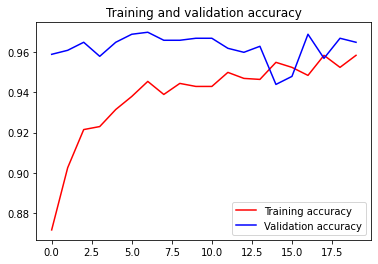

<Figure size 432x288 with 0 Axes>

In [ ]:
import matplotlib.pyplot as plt
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend(loc=0)
plt.figure()


plt.show()

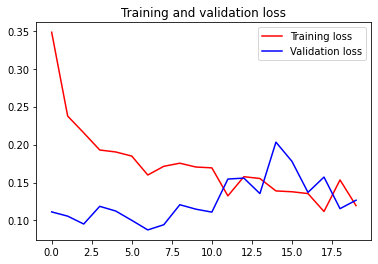

<Figure size 432x288 with 0 Axes>

In [ ]:
# loss
epochs = range(len(loss))
plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend(loc=0)
plt.figure()
plt.show()

In [ ]:
from tensorflow.keras.preprocessing import image
test_file = "drive/MyDrive/ML_colab/dataset/test_cat_dog/cat_2.jpeg"
img = image.load_img(test_file, target_size=(150, 150))
x = image.img_to_array(img)
x = np.expand_dims(x, axis=0)
images = np.vstack([x])

classes = model.predict(images)
classes

array([[0.]], dtype=float32)

In [ ]:
file_path = 'drive/MyDrive/ML_colab/dataset/test_cat_dog/' # current dir
test_files = os.listdir(file_path)

for file in test_files:
    # predicting images
    path=file_path + file
    img=image.load_img(path, target_size=(150, 150))

    x=image.img_to_array(img)
    x=np.expand_dims(x, axis=0)
    images = np.vstack([x])

    classes = model.predict(images, batch_size=10)
    # classes = np.argmax(classes, axis=1)

    print(classes[0])

    if classes[0]>0:
        print(file + " is a dog")

    else:
        print(file + " is a cat")

[0.]
dog4.jpeg is a cat
[0.]
dog1.jpg is a cat
[0.]
dog3.jpg is a cat
[0.]
dog2.jpg is a cat
[0.]
cat.jpeg is a cat
[0.]
cat_2.jpeg is a cat


In [ ]:
labels = (validation_generator.class_indices)
labels = dict((v,k) for k,v in labels.items())
labels

{0: 'cats', 1: 'dogs'}

In [ ]:
steps = validation_generator.n // validation_generator.batch_size
steps


50

In [ ]:
import numpy as np

In [ ]:
validation_generator.reset()
pred = model.predict(validation_generator, verbose=1)
predicted_class_indices=np.argmax(pred,axis=1)
predictions = [labels[k] for k in predicted_class_indices]
predicted_class_indices

50/50 [==============================] - 3s 62ms/step


array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

In [ ]:
pred.size

1000

In [ ]:
predicted_class_indices.size

1000

In [ ]:
pred.shape

(1000, 1)

In [ ]:
pred

array([[1.36149514e-09],
       [1.00000000e+00],
       [2.87727436e-14],
       [1.00000000e+00],
       [1.00000000e+00],
       [1.23545396e-04],
       [2.04234958e-13],
       [9.99999642e-01],
       [2.54900044e-07],
       [9.99899745e-01],
       [9.99990702e-01],
       [1.00000000e+00],
       [1.67346880e-04],
       [6.34718745e-05],
       [2.11994890e-02],
       [1.00000000e+00],
       [9.81615126e-01],
       [1.06514506e-10],
       [1.57966060e-16],
       [2.37735609e-09],
       [1.00000000e+00],
       [9.82553542e-01],
       [1.00000000e+00],
       [9.99987006e-01],
       [9.99999166e-01],
       [4.29406688e-02],
       [2.89321772e-17],
       [2.45170605e-18],
       [1.00000000e+00],
       [1.20776553e-08],
       [7.44812667e-01],
       [1.00000000e+00],
       [2.97828460e-21],
       [1.00000000e+00],
       [1.00000000e+00],
       [1.00000000e+00],
       [1.00000000e+00],
       [1.00000000e+00],
       [1.37697698e-12],
       [1.11869849e-04],
